In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from akita_utils.format_io import h5_to_df

In [3]:
import sys
sys.path.insert(0, "/home1/smaruj/akitaX1-analyses/utils/")
from reading_averaging_utils import average_stat_over_targets

In [4]:
# stat metric the analysis is based on
stat_of_analysis_interest = "SCD"
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_flank_core_compatibility"

In [5]:
keys_to_ignore = ["disruption_SCD_core",
                 "disruption_SCD_flank",
                 "insSCD_group_core",
                 "insSCD_group_flank",
                 "insertion_SCD_core",
                 "insertion_SCD_flank"]

In [6]:
# reading and averaging data for model 0, bg 0
df_m0_bg0 = h5_to_df(data_dir+"/model_0_bg0.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=keys_to_ignore) 
df_m0_bg0_tg = average_stat_over_targets(df_m0_bg0, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [7]:
# reading and averaging data for model 0, bg 0
df_m0_bg1 = h5_to_df(data_dir+"/model_0_bg1.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=keys_to_ignore) 
df_m0_bg1_tg = average_stat_over_targets(df_m0_bg1, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [8]:
# reading and averaging data for model 0, bg 0
df_m0_bg2 = h5_to_df(data_dir+"/model_0_bg2.h5", ["SCD", "INS-16", "INS-64"], average=False, ignore_keys=keys_to_ignore) 
df_m0_bg2_tg = average_stat_over_targets(df_m0_bg2, model_index=0, head_index=1, stat=stat_of_analysis_interest)

In [9]:
df_m0_bg0_tg = df_m0_bg0_tg.sort_values(by="insertion_SCD_core", ascending=False)
df_m0_bg1_tg = df_m0_bg1_tg.sort_values(by="insertion_SCD_core", ascending=False)
df_m0_bg2_tg = df_m0_bg2_tg.sort_values(by="insertion_SCD_core", ascending=False)

In [10]:
unique_core_ends = df_m0_bg0_tg.end_core.unique()

In [11]:
LIST_bg0 = [df_m0_bg0_tg[df_m0_bg0_tg["end_core"] == unique_core_end].sort_values(by="insertion_SCD_flank", ascending=False).SCD_m0 for unique_core_end in unique_core_ends]
LIST_bg1 = [df_m0_bg1_tg[df_m0_bg1_tg["end_core"] == unique_core_end].sort_values(by="insertion_SCD_flank", ascending=False).SCD_m0 for unique_core_end in unique_core_ends]
LIST_bg2 = [df_m0_bg2_tg[df_m0_bg2_tg["end_core"] == unique_core_end].sort_values(by="insertion_SCD_flank", ascending=False).SCD_m0 for unique_core_end in unique_core_ends]

In [12]:
MATRIX_bg0 = np.vstack(LIST_bg0)
MATRIX_bg1 = np.vstack(LIST_bg1)
MATRIX_bg2 = np.vstack(LIST_bg2)

In [13]:
MATRIX = (MATRIX_bg0 + MATRIX_bg1 + MATRIX_bg2) / 3

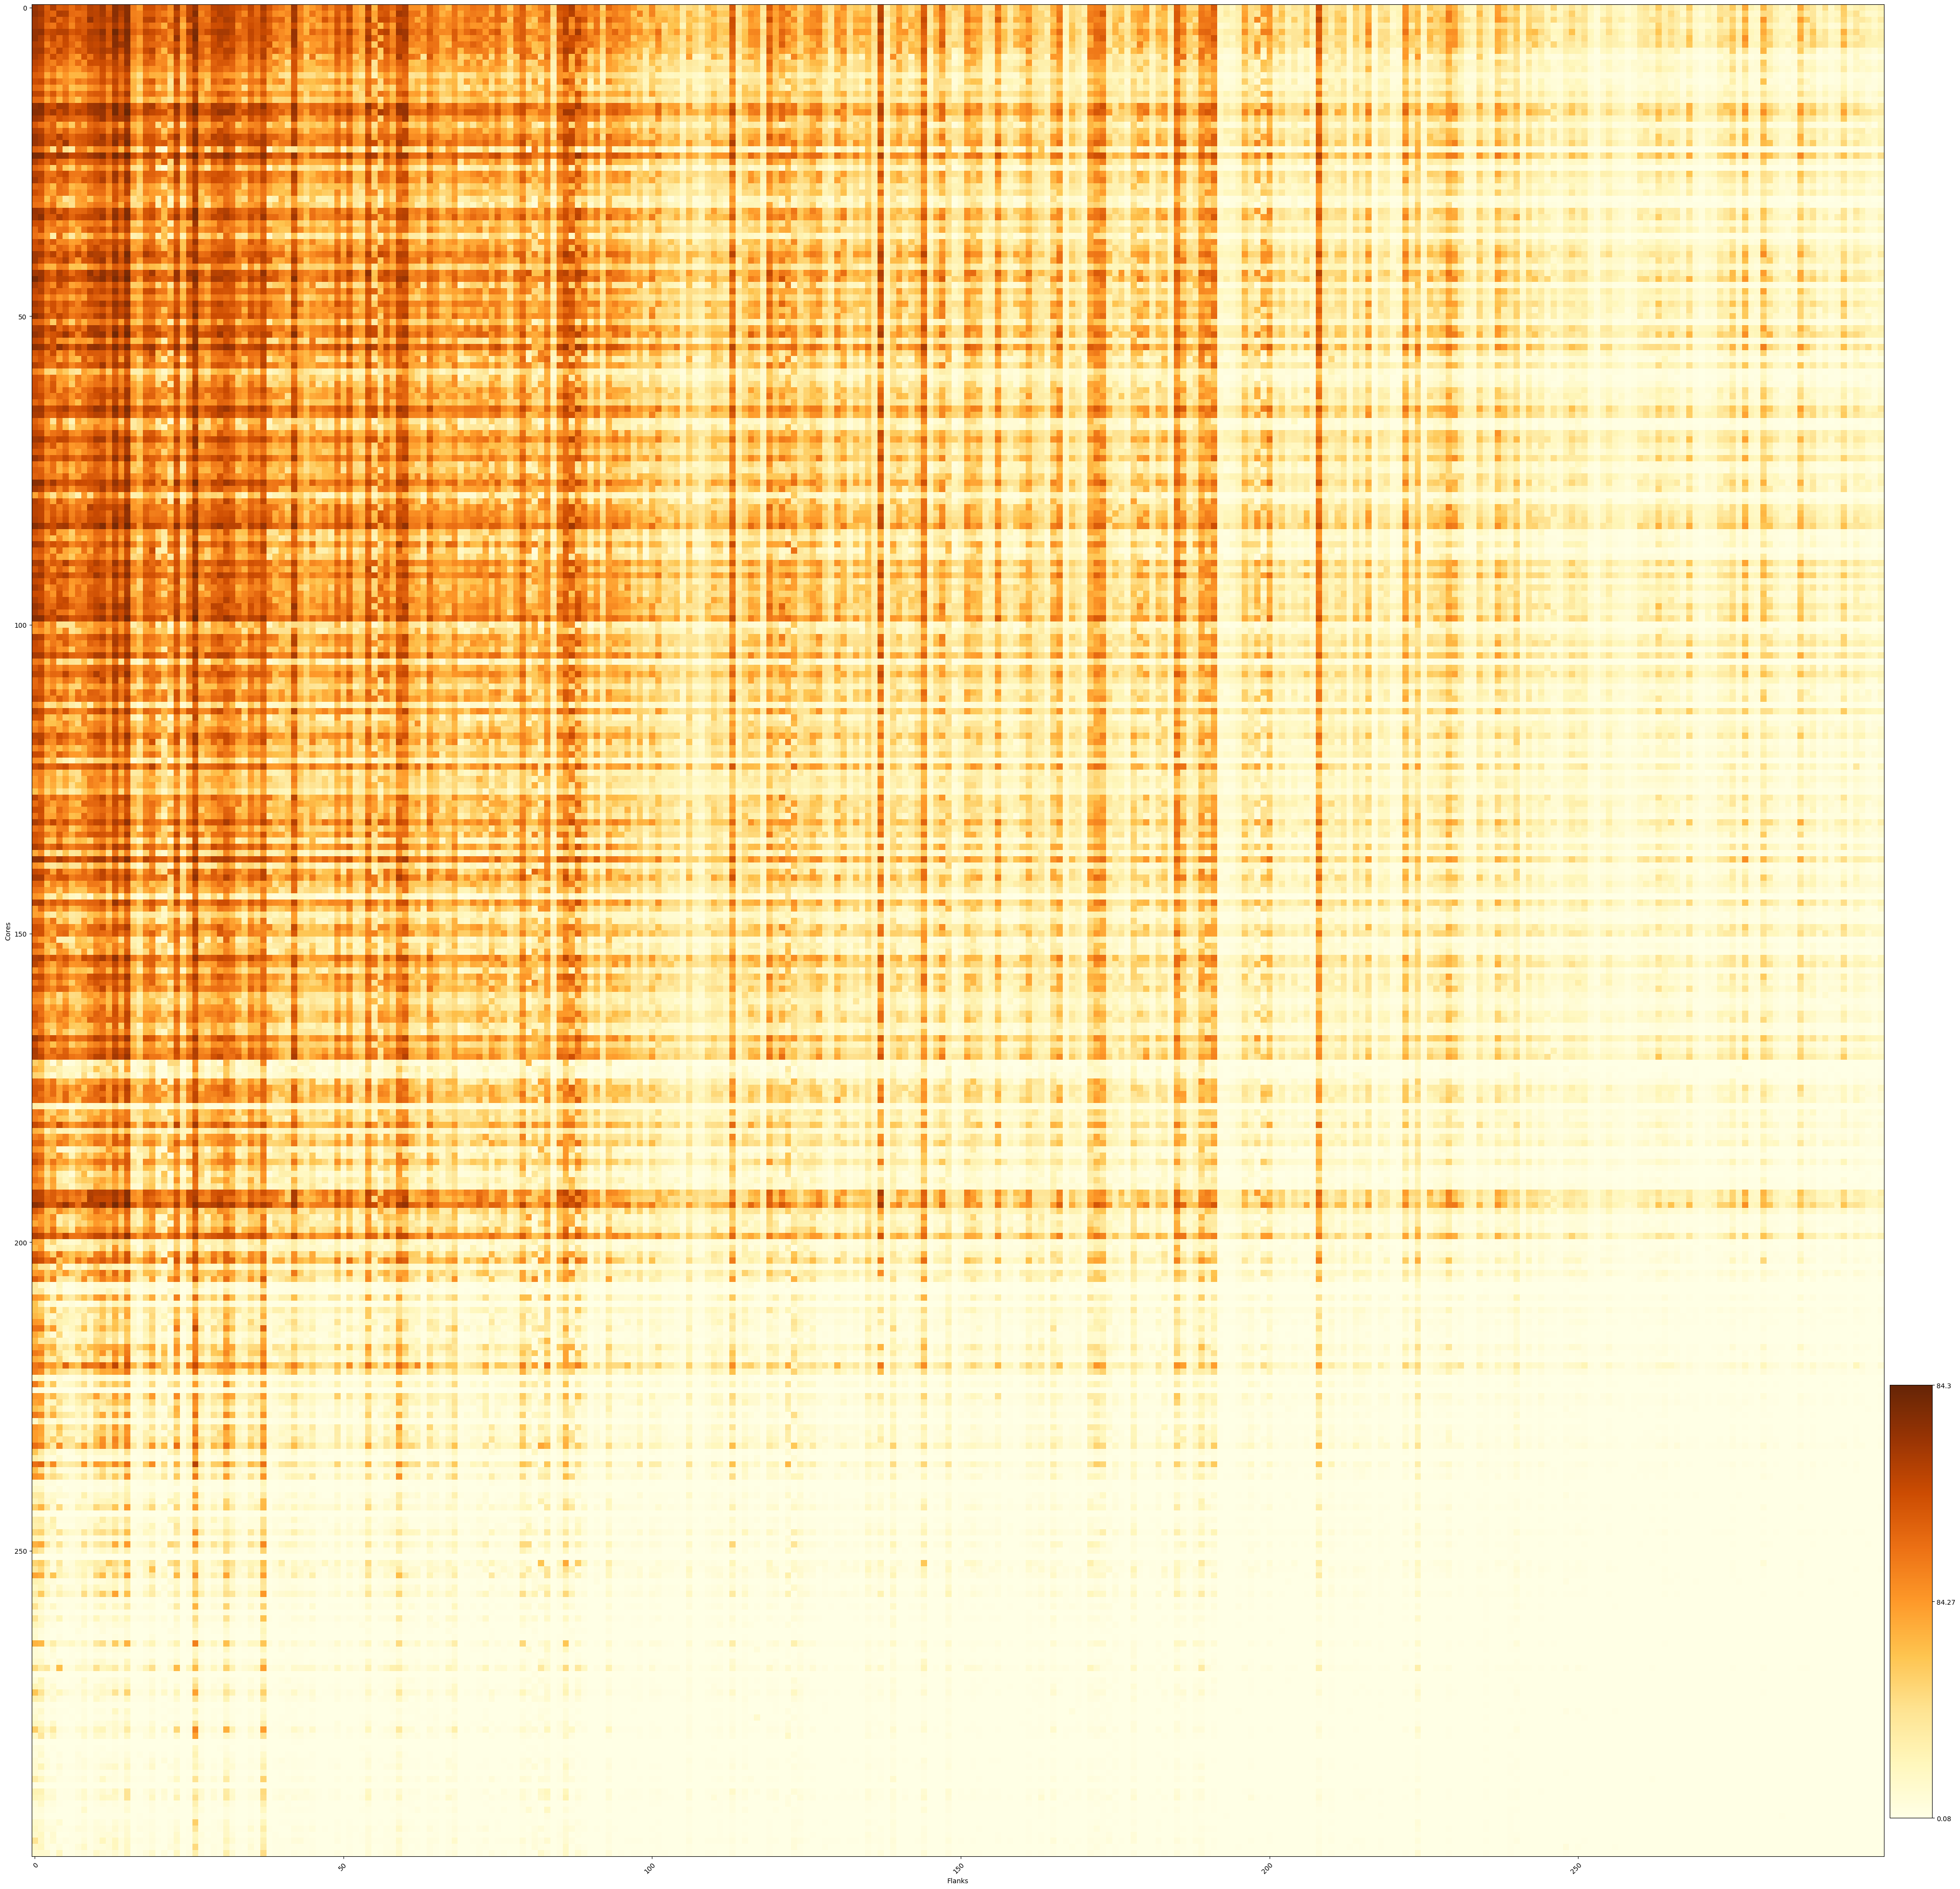

In [14]:
fig, ax = plt.subplots()
im = ax.imshow(MATRIX, cmap="YlOrBr")

fig.set_figheight(50)
fig.set_figwidth(50)

ax.set_ylabel("Cores")
ax.set_xlabel("Flanks")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# ax.set_title("average SCD for the 100 cores versus 100 flanks experiment; motifs sorted by their insertion_SCD, flank length is 25 bp")

cax = plt.axes([0.90, 0.126, 0.0175, 0.18])
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="YlOrBr"), cax=cax, ticks=[0, 0.5, 1])

cbar.ax.set_yticklabels([str(round(np.min(MATRIX),2)), 
                         str(round((np.max(MATRIX) - np.min(MATRIX)/2),2)), 
                         str(round(np.max(MATRIX),2))])

# plt.savefig("100vs100strong_sorted_matplot.png")
plt.show()

## plot the drop in diagonal values

Text(0, 0.5, 'Diagonal value (core with original flanks')

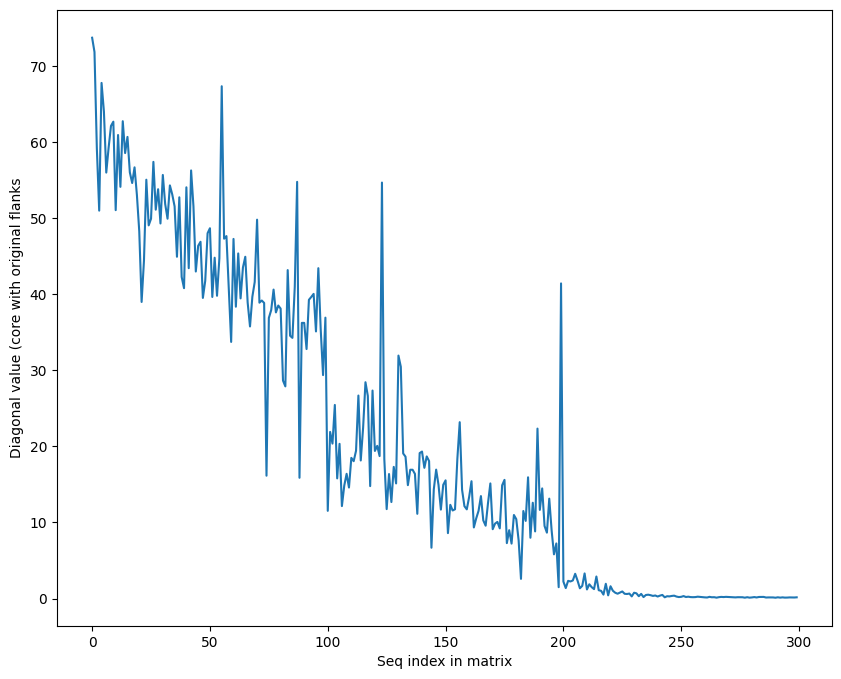

In [15]:
plt.figure(figsize=(10,8))
x = [x for x in range(300)]

plt.plot(x, np.diagonal(MATRIX))

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Seq index in matrix")
plt.ylabel("Diagonal value (core with original flanks")

Text(0, 0.5, 'Insertion_SCD')

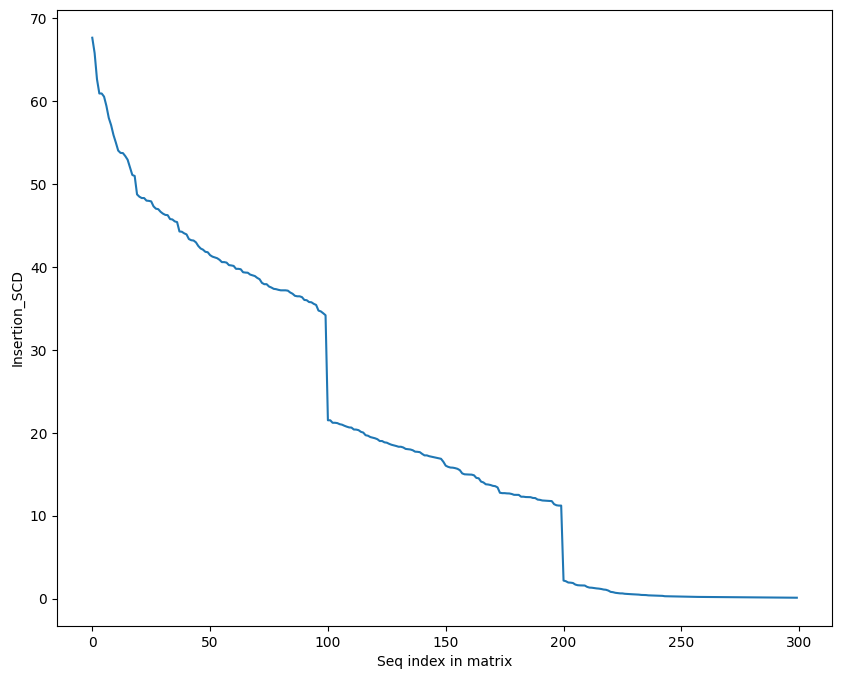

In [16]:
plt.figure(figsize=(10,8))
x = [x for x in range(300)]

plt.plot(x, df_m0_bg0_tg[df_m0_bg0_tg["start_core"] == df_m0_bg0_tg["start_flank"]].insertion_SCD_core)

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Seq index in matrix")
plt.ylabel("Insertion_SCD")

Text(0, 0.5, 'SCD')

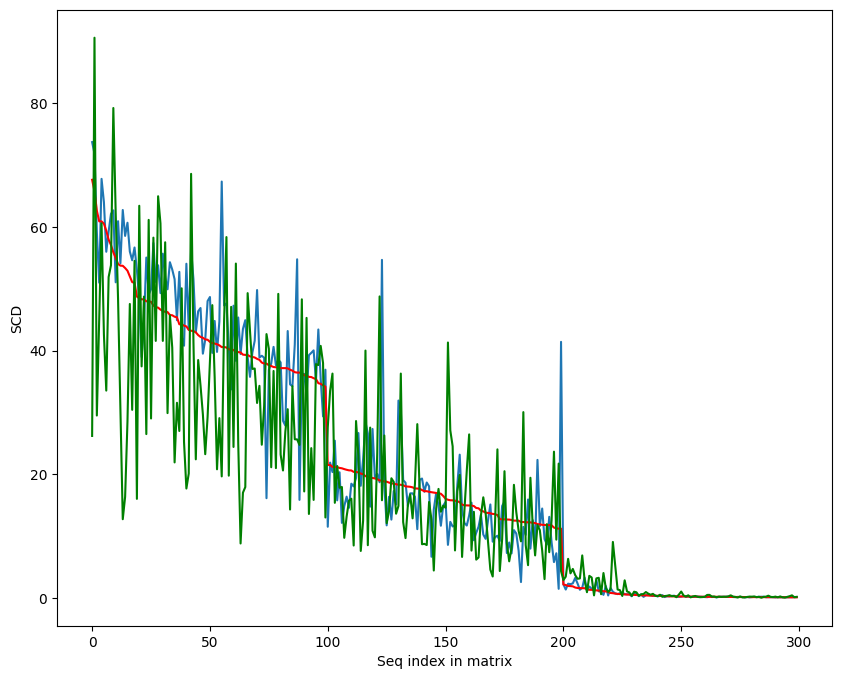

In [17]:
plt.figure(figsize=(10,8))
x = [x for x in range(300)]

plt.plot(x, np.diagonal(MATRIX))
plt.plot(x, df_m0_bg0_tg[df_m0_bg0_tg["start_core"] == df_m0_bg0_tg["start_flank"]].insertion_SCD_core, c="red")
plt.plot(x, df_m0_bg0_tg[df_m0_bg0_tg["start_core"] == df_m0_bg0_tg["start_flank"]].disruption_SCD_core, c="green")

# plt.title("Averaged SCD with respect to the flank lenght")
plt.xlabel("Seq index in matrix")
plt.ylabel("SCD")

## Summary Plot

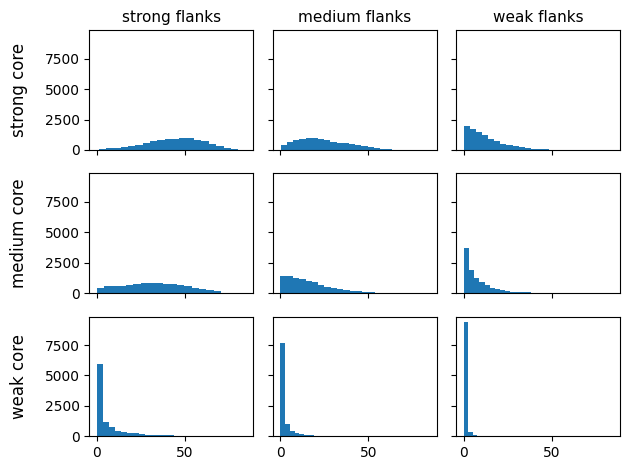

In [18]:
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True, tight_layout=True)

num_bins = 20

# strong core, strong flanks
axs[0,0].hist(MATRIX[0:100, 0:100].flatten(), bins=num_bins)
# strong core, medium flanks
axs[0,1].hist(MATRIX[0:100, 100:200].flatten(), bins=num_bins)
# strong core, weak flanks
axs[0,2].hist(MATRIX[0:100, 200:300].flatten(), bins=num_bins)

# medium core, strong flanks
axs[1,0].hist(MATRIX[100:200, 0:100].flatten(), bins=num_bins)
# medium core, medium flanks
axs[1,1].hist(MATRIX[100:200, 100:200].flatten(), bins=num_bins)
# medium core, weak flanks
axs[1,2].hist(MATRIX[100:200, 200:300].flatten(), bins=num_bins)

# weak core, strong flanks
axs[2,0].hist(MATRIX[200:300, 0:100].flatten(), bins=num_bins)
# weak core, medium flanks
axs[2,1].hist(MATRIX[200:300, 100:200].flatten(), bins=num_bins)
# weak core, weak flanks
axs[2,2].hist(MATRIX[200:300, 200:300].flatten(), bins=num_bins)

cols = ["strong flanks", "medium flanks", "weak flanks"]
rows = ["strong core", "medium core", "weak core"]

for ax, col in zip(axs[0], cols):
    ax.set_title(col, size=11)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, fontsize=12, labelpad=12)

In [19]:
# before the dtype was float16, all the SDs I got were inf
MATRIX = MATRIX.astype(int)

In [20]:
print("strong core, strong flanks: ", "MEAN=", np.mean(MATRIX[0:100, 0:100]), "SD=", np.std(MATRIX[0:100, 0:100]))
print("strong core, medium flanks: ", "MEAN=", np.mean(MATRIX[0:100, 100:200]), "SD=", np.std(MATRIX[0:100, 100:200]))
print("strong core, weak flanks: ", "MEAN=", np.mean(MATRIX[0:100, 200:300]), "SD=", np.std(MATRIX[0:100, 200:300]))

print("medium core, strong flanks: ", "MEAN=", np.mean(MATRIX[100:200, 0:100]), "SD=", np.std(MATRIX[100:200, 0:100]))
print("medium core, medium flanks: ", "MEAN=", np.mean(MATRIX[100:200, 100:200]), "SD=", np.std(MATRIX[100:200, 100:200]))
print("medium core, weak flanks: ", "MEAN=", np.mean(MATRIX[100:200, 200:300]), "SD=", np.std(MATRIX[100:200, 200:300]))

print("weak core, strong flanks: ", "MEAN=", np.mean(MATRIX[200:300, 0:100]), "SD=", np.std(MATRIX[200:300, 0:100]))
print("weak core, medium flanks: ", "MEAN=", np.mean(MATRIX[200:300, 100:200]), "SD=", np.std(MATRIX[200:300, 100:200]))
print("weak core, weak flanks: ", "MEAN=", np.mean(MATRIX[200:300, 200:300]), "SD=", np.std(MATRIX[200:300, 200:300]))

strong core, strong flanks:  MEAN= 43.6379 SD= 15.990828108325095
strong core, medium flanks:  MEAN= 24.2343 SD= 14.27129298662178
strong core, weak flanks:  MEAN= 12.3304 SD= 10.893100377762064
medium core, strong flanks:  MEAN= 31.8352 SD= 17.2568954612352
medium core, medium flanks:  MEAN= 16.0266 SD= 12.452738351061585
medium core, weak flanks:  MEAN= 7.2529 SD= 8.348193911859019
weak core, strong flanks:  MEAN= 6.4935 SD= 10.84516287337355
weak core, medium flanks:  MEAN= 2.1549 SD= 4.889387077129403
weak core, weak flanks:  MEAN= 0.5083 SD= 2.1451645880910863
